In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('datasets/dataset_train.csv')[['Hogwarts House', 'Herbology', 'Defense Against the Dark Arts',
       'Divination', 'Muggle Studies', 'Ancient Runes', 'History of Magic',
       'Transfiguration', 'Care of Magical Creatures', 'Charms', 'Flying']]
df.head()

,Hogwarts House,Herbology,Defense Against the Dark Arts,Divination,Muggle Studies,Ancient Runes,History of Magic,Transfiguration,Care of Magical Creatures,Charms,Flying
0,Ravenclaw,5.727180,4.878861,4.722,272.035831,532.484226,5.231058,1039.788281,0.715939,-232.79405,-26.89
1,Slytherin,-5.987446,5.520605,-5.612,-487.340557,367.760303,4.107170,1058.944592,0.091674,-252.18425,-113.45
2,Ravenclaw,7.725017,3.660761,6.140,664.893521,602.585284,3.555579,1088.088348,-0.515327,-227.34265,30.42
3,Gryffindor,-6.497214,-6.977428,4.026,-537.001128,523.982133,-4.809637,920.391449,-0.014040,-256.84675,200.64
4,Gryffindor,-7.820623,NaN,2.236,-444.262537,599.324514,-3.444377,937.434724,-0.264070,-256.38730,157.98


In [3]:
# for train: Ravenclaw -> Slytherin -> Gryffindor
df = df[['Hogwarts House', 'Muggle Studies', 'Charms', 'Divination', 'Flying', 'History of Magic', 'Transfiguration']]
df.head()

,Hogwarts House,Muggle Studies,Charms,Divination,Flying,History of Magic,Transfiguration
0,Ravenclaw,272.035831,-232.79405,4.722,-26.89,5.231058,1039.788281
1,Slytherin,-487.340557,-252.18425,-5.612,-113.45,4.107170,1058.944592
2,Ravenclaw,664.893521,-227.34265,6.140,30.42,3.555579,1088.088348
3,Gryffindor,-537.001128,-256.84675,4.026,200.64,-4.809637,920.391449
4,Gryffindor,-444.262537,-256.38730,2.236,157.98,-3.444377,937.434724


In [124]:
df.shape[0]

1452

In [4]:
df.shape[0] - df.dropna().shape[0]

148

In [5]:
df = df.dropna()

In [16]:
def get_minmax(x):
    x_minmax = np.zeros([x.shape[1], 2], np.float32)
    for i in range(x.shape[1]):
        x_minmax[i] = [x[:, i].min(), x[:, i].max()]
    return x_minmax

def normalization(target, val_min, val_max):
    return (target - val_min) / (val_max - val_min)

def set_xnorm(x, x_minmax):
    for i in range(x.shape[1]):
        x[:, i] = normalization(x[:, i], *x_minmax[i])

y = df.values[:, 0]
x = df.values[:, 1:].astype(np.float32)
x_minmax = get_minmax(x)
set_xnorm(x, x_minmax)
bias = np.ones((x.shape[0], 1))
x = np.concatenate((x, bias), 1)

In [121]:
def sigmoid(predict):
    sigmoid = 1 / (1 + np.exp(-predict))
    return sigmoid

# def loss_log(y, predict):
#     loss_log = -np.mean(y * np.log(predict) +
#                         (1 - y) * np.log(1 - predict))
#     return loss_log

def loss_log(predict, y, target):

    y =  np.array(list(map(lambda x: 1 if x == target else 0, y)))
    # if target == 'Ravenclaw':
    #     y =  np.array(list(map(lambda x: 1 if x == target else 0, y)))
    # else:
    #     y =  np.array(list(map(lambda x: 0 if x == target else 1, y)))

    loss_log = -np.mean(y * np.log(predict) +
                        (1 - y) * np.log(1 - predict))
    return loss_log

In [128]:
weight = np.random.random(x.shape[1] + 2)
delta = np.zeros(weight.size, np.float32)
# alpha = np.array([0.01] * weight.size, np.float32) #maybe change to scalar
alpha = 0.01
epochs = 200
error = np.zeros([epochs, 3], np.float32)
for j in range(epochs):

    predict_r = sigmoid(np.concatenate([x[:, 0:2],
                                        x[:, -1].reshape(-1, 1)],
                                    axis=1) @ weight[0:3])
    
    predict_s = sigmoid(np.concatenate([x[:, 2:4],
                                        x[:, -1].reshape(-1, 1)],
                                    axis=1) @ weight[3:6])

    predict_g = sigmoid(np.concatenate([x[:, 4:6],
                                        x[:, -1].reshape(-1, 1)],
                                    axis=1) @ weight[6:9])

    error[j][0] = loss_log(predict_r, y, 'Ravenclaw')
    error[j][1] = loss_log(predict_s, y, 'Slytherin')
    error[j][2] = loss_log(predict_g, y, 'Gryffindor')


    for i in range(x.shape[0]):

        predict_r = sigmoid(np.concatenate([x[i][0:2],
                                    [x[i][-1]]]) @ weight[0:3])

        delta[0:3] += (predict_r - int(y[i] == 'Ravenclaw')) *\
                        (predict_r * (1 - predict_r)) *\
                        np.concatenate([x[i][0:2], [x[i][-1]]])


        predict_s = sigmoid(np.concatenate([x[i][2:4],
                                    [x[i][-1]]]) @ weight[3:6])

        delta[3:6] += (predict_s - int(y[i] == 'Slytherin')) *\
                        (predict_s * (1 - predict_s)) *\
                        np.concatenate([x[i][2:4], [x[i][-1]]])


        predict_g = sigmoid(np.concatenate([x[i][4:6],
                                    [x[i][-1]]]) @ weight[6:9])

        delta[6:9] += (predict_g - int(y[i] == 'Gryffindor')) *\
                        (predict_g * (1 - predict_g)) *\
                        np.concatenate([x[i][4:6], [x[i][-1]]])
    
    weight -= delta * alpha
    delta[:] = 0


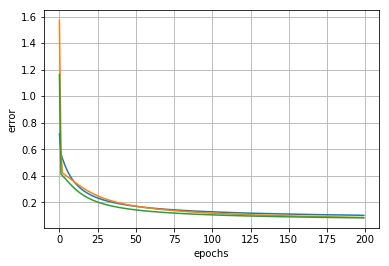

In [129]:
# plt.plot(range(epochs), error[:, 0])
plt.plot(range(epochs), error)
plt.xlabel('epochs')
plt.ylabel('error')
plt.grid()
plt.show()

In [130]:
error[-1]

array([0.10121056, 0.08535934, 0.08151308], dtype=float32)